# Data Analysis of the IRN

In [101]:
import typing

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

np.random.seed(7)
plt.style.use("ggplot")
COLOR = "teal"

## Preprocessing the table

In [2]:
PATH = "../data/Train_details_22122017.csv"
df = pd.read_csv(PATH, header=0)

/tmp/ipykernel_1161443/2682166886.py:2: DtypeWarning: Columns (0,2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PATH, header=0)


In [3]:
print("Rows with at least one NA value:", df.isna().any(axis=1).value_counts()[True])

Rows with at least one NA value: 10


In [4]:
# Since this is a small number, we can just drop these rows.
df.dropna(inplace=True, how="any")
# Reset the index as dropping rows deletes the index values creating jumps.
# If row 2 were deleted. The index would be 0, 1, 3, 4, ...
df.reset_index(drop=True, inplace=True)

In [5]:
df.columns

Index(['Train No', 'Train Name', 'SEQ', 'Station Code', 'Station Name',
       'Arrival time', 'Departure Time', 'Distance', 'Source Station',
       'Source Station Name', 'Destination Station',
       'Destination Station Name'],
      dtype='object')

In [6]:
df.head()

,Train No,Train Name,SEQ,Station Code,Station Name,Arrival time,Departure Time,Distance,Source Station,Source Station Name,Destination Station,Destination Station Name
0,107,SWV-MAO-VLNK,1,SWV,SAWANTWADI R,0:00:00,10:25:00,0,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
1,107,SWV-MAO-VLNK,2,THVM,THIVIM,11:06:00,11:08:00,32,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
2,107,SWV-MAO-VLNK,3,KRMI,KARMALI,11:28:00,11:30:00,49,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
3,107,SWV-MAO-VLNK,4,MAO,MADGOAN JN.,12:10:00,0:00:00,78,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
4,108,VLNK-MAO-SWV,1,MAO,MADGOAN JN.,0:00:00,20:30:00,0,MAO,MADGOAN JN.,SWV,SAWANTWADI ROAD


In [7]:
# Change int columns to have int datatype
df = df.astype({
    "Train No": int,
    "SEQ": int,
    "Distance": int
})
# Change time columns to have time datatype
df["Arrival time"] = pd.to_datetime(df["Arrival time"], format="%H:%M:%S").dt.time
df["Departure Time"] = pd.to_datetime(df["Departure Time"], format="%H:%M:%S").dt.time

## Extract graph

In [8]:
def generate_graph(dataframe: pd.DataFrame, distance_weighted: bool = False, directed:bool = False) -> nx.DiGraph:
    '''
    Generate a graph where edges are rail tracks.
    '''
    # Create an empty directed graph.
    graph = nx.DiGraph() if directed else nx.Graph()
    # Iterate over the "Station Code" series. Skip the first station.
    for i in range(1, dataframe["Station Code"].shape[0]):
        # Get the current and previous station.
        current_station = dataframe["Station Code"][i]
        previous_station = dataframe["Station Code"][i - 1]

        # If the train no. doesn't match between the two stations, ignore.
        if dataframe["Train No"][i] != dataframe["Train No"][i - 1]:
            continue

        # Set the edge weight to the distance between the current station
        # and the previous station if using distance as the edge weight.
        # Set the edge weight to 1 if using #trains as weights.
        edge_weight = dataframe["Distance"][i] if distance_weighted else 1

        # If no edge exists:
        if not graph.has_edge(previous_station, current_station):
            # Add an edge and set the appropriate weight.
            graph.add_edge(previous_station, current_station, weight=edge_weight)
        # Else, increment the weight if edge weight is #trains.
        else:
            if not distance_weighted:
                graph.edges[previous_station, current_station]["weight"] += edge_weight
    return graph

In [122]:
STATION_CODE = 'Station Code'
SOURCE_STATION = 'Source Station'
DESTINATION_STATION = 'Destination Station'
TRAIN_NAME = 'Train Name'
TRAIN_NO = 'Train No'
DISTANCE = 'Distance'

def generate_graph(railway_data, filter_nodes=None, distance_weighted=False, directed: bool = False):
    '''
    Genearte a graph where edges are trains. Two stations are connected
    if we can reach one station from the other without switching trains.
    '''
    # make an empty directed graph
    graph = nx.DiGraph() if directed else nx.Graph()
    stations = None

    # add all stations if there are none to filter
    if filter_nodes==None:
      stations = np.unique(railway_data[STATION_CODE])
    else:
      stations = filter_nodes
    
    graph.add_nodes_from(stations)
    
    # find all unique trains
    trains = np.unique(railway_data[TRAIN_NAME].astype('str'))
    
    # iterate over all trains
    for train_name in trains:

      # find out the stations the train visits
      train_route = railway_data.loc[railway_data[TRAIN_NAME] == train_name]
      stations_in_route = train_route[STATION_CODE].to_list()
      station_distances = train_route[DISTANCE].to_list()

      # make a connected graph out of all stations in route
      for source_station_itr in range(len(stations_in_route)):
        for destination_station_itr in range(source_station_itr+1, len(stations_in_route)):
          # Only add edge if node is present in the nodes to be filtered, or no node is to be filtered (i.e. add all)
          if filter_nodes==None \
            or stations_in_route[source_station_itr] in filter_nodes \
            or stations_in_route[destination_station_itr] in filter_nodes:

            if distance_weighted:
              # edge weight is the distance between the two nodes
              distance = int(station_distances[destination_station_itr]) \
                - int(station_distances[source_station_itr])
            else:
              # edge weight is the number of trains passing through the two stations
              distance = 1

            # if edge exists already then increment weight
            if graph.has_edge(
               stations_in_route[source_station_itr],
               stations_in_route[destination_station_itr]
            ):
                graph[stations_in_route[source_station_itr]][stations_in_route[destination_station_itr]]['weight'] += distance
            else:
                graph.add_edge(
                   stations_in_route[source_station_itr],
                   stations_in_route[destination_station_itr],
                   weight=distance,
                   label=train_name
                )
    return graph

## Analysis
Replicating the results from Ghosh, Saptarshi et al. “STATISTICAL ANALYSIS OF THE INDIAN RAILWAY NETWORK: A COMPLEX NETWORK APPROACH.” (2011).

In [133]:
irn = generate_graph(df, distance_weighted=False)
print(irn)

Graph with 8147 nodes and 500412 edges


In [124]:
avg_degree = 2 * irn.number_of_edges() / irn.number_of_nodes()
print("Average degree:", avg_degree)

Average degree: 122.84571007732907


In [125]:
print("#Connected components:", nx.number_connected_components(irn))

for cc in nx.connected_components(irn):
    print(len(cc))

#Connected components: 7
8059
29
12
3
17
10
17


In [ ]:
#! Don't run unless necessary. This takes more than half an hour.
# Compute the weighted mean of average path length among the connected components.
cc_len = []
cc_shortest_path_len = []
for cc in nx.connected_components(irn):
    graph = nx.subgraph(irn, cc)
    avg_shortest_path = nx.average_shortest_path_length(graph)
    cc_len.append(len(cc))
    cc_shortest_path_len.append(avg_shortest_path)

In [ ]:
print("Cluster size:", cc_len)
print("Cluster avg shortest path lengths:", cc_shortest_path_len)
print("Average shortest path length:", sum(cc_shortest_path_len) / len(cc_shortest_path_len))
print(
    "Weighted average shortest path length:",
    sum([i * j for i, j in zip(cc_len, cc_shortest_path_len)]) / sum(cc_len)
)

In [5]:
# Values obtained by running above cell.
cc_len = [8059, 29, 12, 3, 17, 10, 17]
cc_shortest_path_len = [2.884512707858718, 1.0369458128078817, 1.1363636363636365, 1.3333333333333333, 1.0, 1.2666666666666666, 1.0]
print("Average shortest path length:", sum(cc_shortest_path_len) / len(cc_shortest_path_len))
print("Weighted average shortest path length:",
      sum([i * j for i, j in zip(cc_len, cc_shortest_path_len)]) / sum(cc_len))

Average shortest path length: 1.3796888795757478
Weighted average shortest path length: 2.8649395325282763


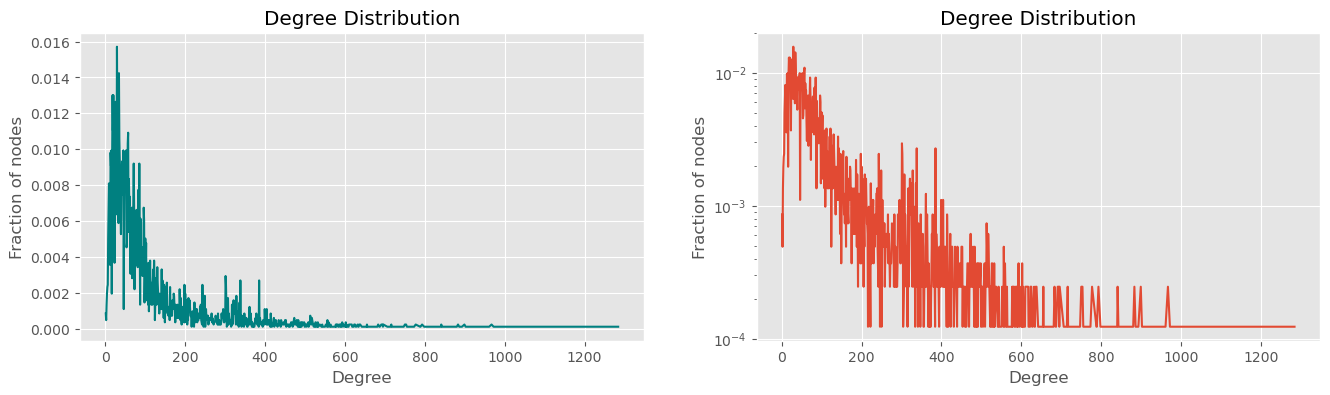

In [165]:
degree_sequence = sorted((d for n, d in irn.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree Distribution", figsize=(16, 4))

plt.subplot(1,2,1)
plt.plot(
    np.unique(degree_sequence, return_counts=True)[0],
    np.unique(degree_sequence, return_counts=True)[1] / irn.number_of_nodes(),
    color=COLOR,
)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Fraction of nodes")

plt.subplot(1,2,2)
plt.semilogy(
    np.unique(degree_sequence, return_counts=True)[0],
    np.unique(degree_sequence, return_counts=True)[1] / irn.number_of_nodes(),
)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Fraction of nodes")

plt.show()

The degree distribution is often quite noise. It is better to work with cumulative degree distribution.</br>
Cumulative degree distribution shows the fraction of nodes having at least degree k.

### Figure 2a

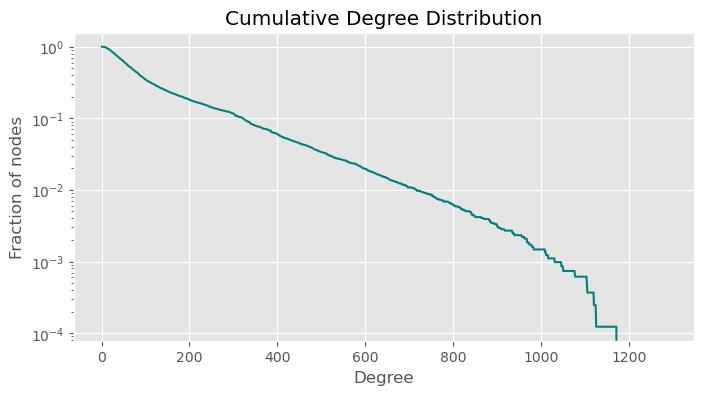

In [168]:
degree_sequence = sorted((d for n, d in irn.degree()))
unique, count = np.unique(degree_sequence, return_counts=True)
count_dict = {k: v for k, v in zip(unique, count)}

dmax = max(degree_sequence)
degrees = list(range(1, dmax))
degree_dist = []
# skip 0.
for i in range(1, dmax):
    if i in unique:
        degree_dist.append(count_dict[i])
    else:
        degree_dist.append(0)

# Compute cumulative sum on the reverse order. Reverse the list again for plots.
cumulative_degree_dist = np.cumsum(degree_dist[::-1])[::-1] / irn.number_of_nodes()

plt.figure(figsize=(8, 4))
plt.semilogy(degrees, cumulative_degree_dist, color=COLOR)

plt.title("Cumulative Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Fraction of nodes")
plt.show()

### Figure 2b

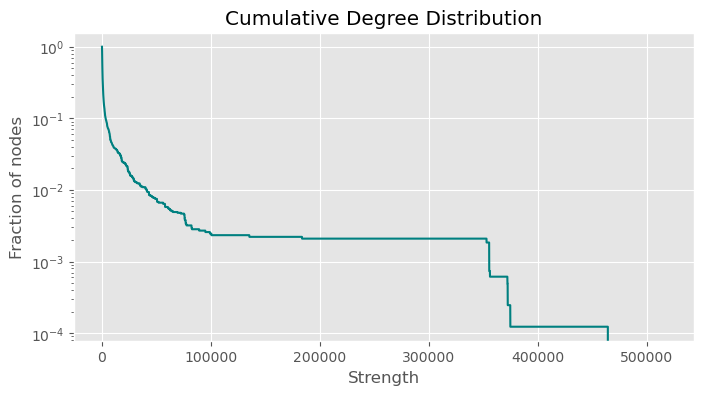

In [169]:
strength_sequence = sorted((d for n, d in irn.degree(weight="weight")))
unique, count = np.unique(strength_sequence, return_counts=True)
count_dict = {k: v for k, v in zip(unique, count)}

smax = max(strength_sequence)
strengths = list(range(1, smax))
strength_dist = []
# skip 0.
for i in range(1, smax):
    if i in unique:
        strength_dist.append(count_dict[i])
    else:
        strength_dist.append(0)

# Compute cumulative sum on the reverse order. Reverse the list again for plots.
cumulative_strength_dist = np.cumsum(strength_dist[::-1])[::-1] / irn.number_of_nodes()

plt.figure(figsize=(8, 4))
plt.semilogy(strengths, cumulative_strength_dist, color=COLOR)

plt.title("Cumulative Degree Distribution")
plt.xlabel("Strength")
plt.ylabel("Fraction of nodes")
plt.show()

In [170]:
print("Top 10 stations based on #journeys:")
sorted(
    ((n,d) for n, d in irn.degree(weight="weight")),
    key=lambda x: x[1],
    reverse=True
)[:10]

Top 10 stations based on #journeys:


[('MSB', 517109),
 ('TBM', 464104),
 ('MS', 374552),
 ('STM', 372205),
 ('MKK', 372171),
 ('PV', 371903),
 ('MBM', 355889),
 ('GDY', 355211),
 ('MN', 355194),
 ('MPK', 355194)]

### Figure 3a

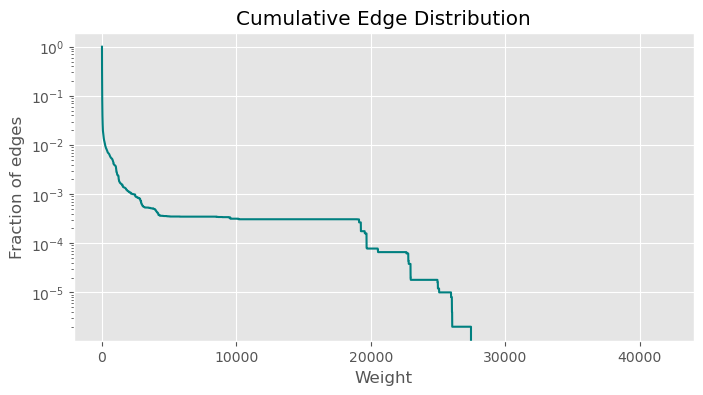

In [181]:
edge_sequence = sorted((irn.edges[edge]["weight"] for edge in irn.edges()))
unique, count = np.unique(edge_sequence, return_counts=True)
count_dict = {k: v for k, v in zip(unique, count)}

wmax = max(edge_sequence)
weights = list(range(1, wmax))
weight_dist = []
# skip 0.
for i in range(1, wmax):
    if i in unique:
        weight_dist.append(count_dict[i])
    else:
        weight_dist.append(0)

# Compute cumulative sum on the reverse order. Reverse the list again for plots.
cumulative_weight_dist = np.cumsum(weight_dist[::-1])[::-1] / irn.number_of_edges()

plt.figure(figsize=(8, 4))
plt.semilogy(weights, cumulative_weight_dist, color=COLOR)
# plt.plot(weights, cumulative_weight_dist, color=COLOR)

plt.title("Cumulative Edge Distribution")
plt.xlabel("Weight")
plt.ylabel("Fraction of edges")
plt.show()

In [182]:
print("Top 10 edges based on weight:")
sorted(
    ((edge, irn.edges[edge]["weight"]) for edge in irn.edges()),
    key = lambda x: x[1],
    reverse=True
)[:10]

Top 10 edges based on weight:


[(('MSB', 'TBM'), 41923),
 (('MSB', 'MSB'), 27446),
 (('MS', 'MSB'), 26043),
 (('MSB', 'STM'), 26026),
 (('MKK', 'MSB'), 26022),
 (('MSB', 'PV'), 25958),
 (('MS', 'TBM'), 25071),
 (('STM', 'TBM'), 24980),
 (('MKK', 'TBM'), 24978),
 (('PV', 'TBM'), 24948)]

### Figure 3b